# 客户分群RFM 模型

- R:recently,最近一次购物距离今天的时间，代表用户忠诚度
- F:frequency,用户在一段时间内的购物频次，代表用户活跃度
- M:money,用户在一段时间内的购物金额，代表用户的消费水平
在RFM分析中，确定好R，F，M的值之后，我们会用1-5分将客户区分，在recency维度上1代表最远日期，5代表最近的日期，所以1代表更重要的用户；在frequenct维度上1代表最低购物频次，5代表最高购物频次；在消费金额维度上，1代表消费金额最低水平，5为消费金额最高水平
<img src='https://miro.medium.com/v2/resize:fit:828/format:webp/1*oUKMc3gk53hccFX4YNeu1g.png'>

## 数据分析
- 数据源：[线上零售系统交易订单2009-2011年公开数据集](https://archive.ics.uci.edu/dataset/502/online+retail+ii)
- 字段解释
    - InvoiceNo: Invoice number(发票号码). Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
    - StockCode: Product (item) code（商品编号）. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
    - Description（商品描述）: Product (item) name. Nominal. 
    - Quantity（购买商品数量）: The quantities of each product (item) per transaction. Numeric.	
    - InvoiceDate（开票时间）: Invice date and time. Numeric. The day and time when a transaction was generated. 
    - UnitPrice（商品单价）: Unit price. Numeric. Product price per unit in sterling (Â£). 
    - CustomerID（用户ID）: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
    - Country（国家）: Country name. Nominal. The name of the country where a customer resides.

In [2]:
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x:'%.5f'%x)
filepath = 'C:\\Users\\wz\\Downloads\\online+retail+ii\\online_retail_II.xlsx'

In [4]:
# 2009-2011年数据读入
all_sheet = pd.read_excel(filepath,sheet_name=None)#字典：以sheet_name为键，以数据为值
data = pd.DataFrame()
for sheet in all_sheet.values():
    data = pd.concat([data,sheet],ignore_index=True)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


## 以2009-2010年数据为例

In [5]:
df = pd.read_excel(filepath,sheet_name='Year 2009-2010')#读取数据所需时间较长
df = df.copy()
df.head()#查看字段

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [6]:
df.shape#数据维度

(525461, 8)

In [7]:
df[['Quantity','Price']].describe().T#查看数值型分布是否异常

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.00000,10.33767,107.42411,-9600.00000,1.00000,3.00000,10.00000,19152.00000
Price,525461.00000,4.68883,146.12691,-53594.36000,1.25000,2.10000,4.21000,25111.09000


### 数据预处理
- 缺失值删除
- 异常值删除
- 数据类型转换

In [8]:
#删除缺失值
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [9]:
df.dropna(inplace=True)#在原表上删除
#删除不符合实际意义的数据，价格和订购数量非负
df = df[(df['Quantity']>=0) & (df['Price']>=0)]
#删除退订数据，发票以C开头
df = df[~df['Invoice'].apply(str).str.contains('C')]

In [10]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'].apply(lambda x:x.date()))

In [11]:
df.shape

(407695, 8)

### 商品热度分析
- 年度销售商品品类总数
- 订单中提及最多的商品
- 订购数量最多的商品

In [12]:
#销售商品种类数
df['StockCode'].nunique()

4017

In [13]:
#订单中提及最多的商品前10
df['StockCode'].value_counts().head(10)

85123A    3153
85099B    1742
22423     1706
21212     1586
21232     1407
84879     1369
20725     1361
21754     1219
84991     1189
21034     1189
Name: StockCode, dtype: int64

In [14]:
#订购数量降序表
df.groupby('StockCode').agg({'Quantity':'sum'}).sort_values('Quantity',ascending=False)

,Quantity
StockCode,
21212,57570
85123A,56915
84077,54754
85099B,48802
17003,48166
84879,44551
84991,35806
21977,31006
22197,28788


### RFM模型相关指标计算

In [15]:
#消费总金额
df['TotalPrice'] = df['Quantity']*df['Price']

In [16]:
#计算消费间隔的基准日，以所有数据最大日期的后一天为基准
base_date = max(df['InvoiceDate'])+dt.timedelta(days=1)

In [17]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate':lambda date:(base_date-date.max()).days,
                                    'Invoice':lambda num:num.nunique(),
                                    'TotalPrice':lambda TotalPrice:TotalPrice.sum()})
rfm.rename(columns = {'InvoiceDate':'recency','Invoice':'frequency','TotalPrice':'monetary'},inplace=True)#更改列名
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.00000,165,11,372.86000
12347.00000,3,2,1323.32000
12348.00000,74,1,222.16000
12349.00000,43,3,2671.14000
12351.00000,11,1,300.93000


### 查看R、F、M指标数据分布情况

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

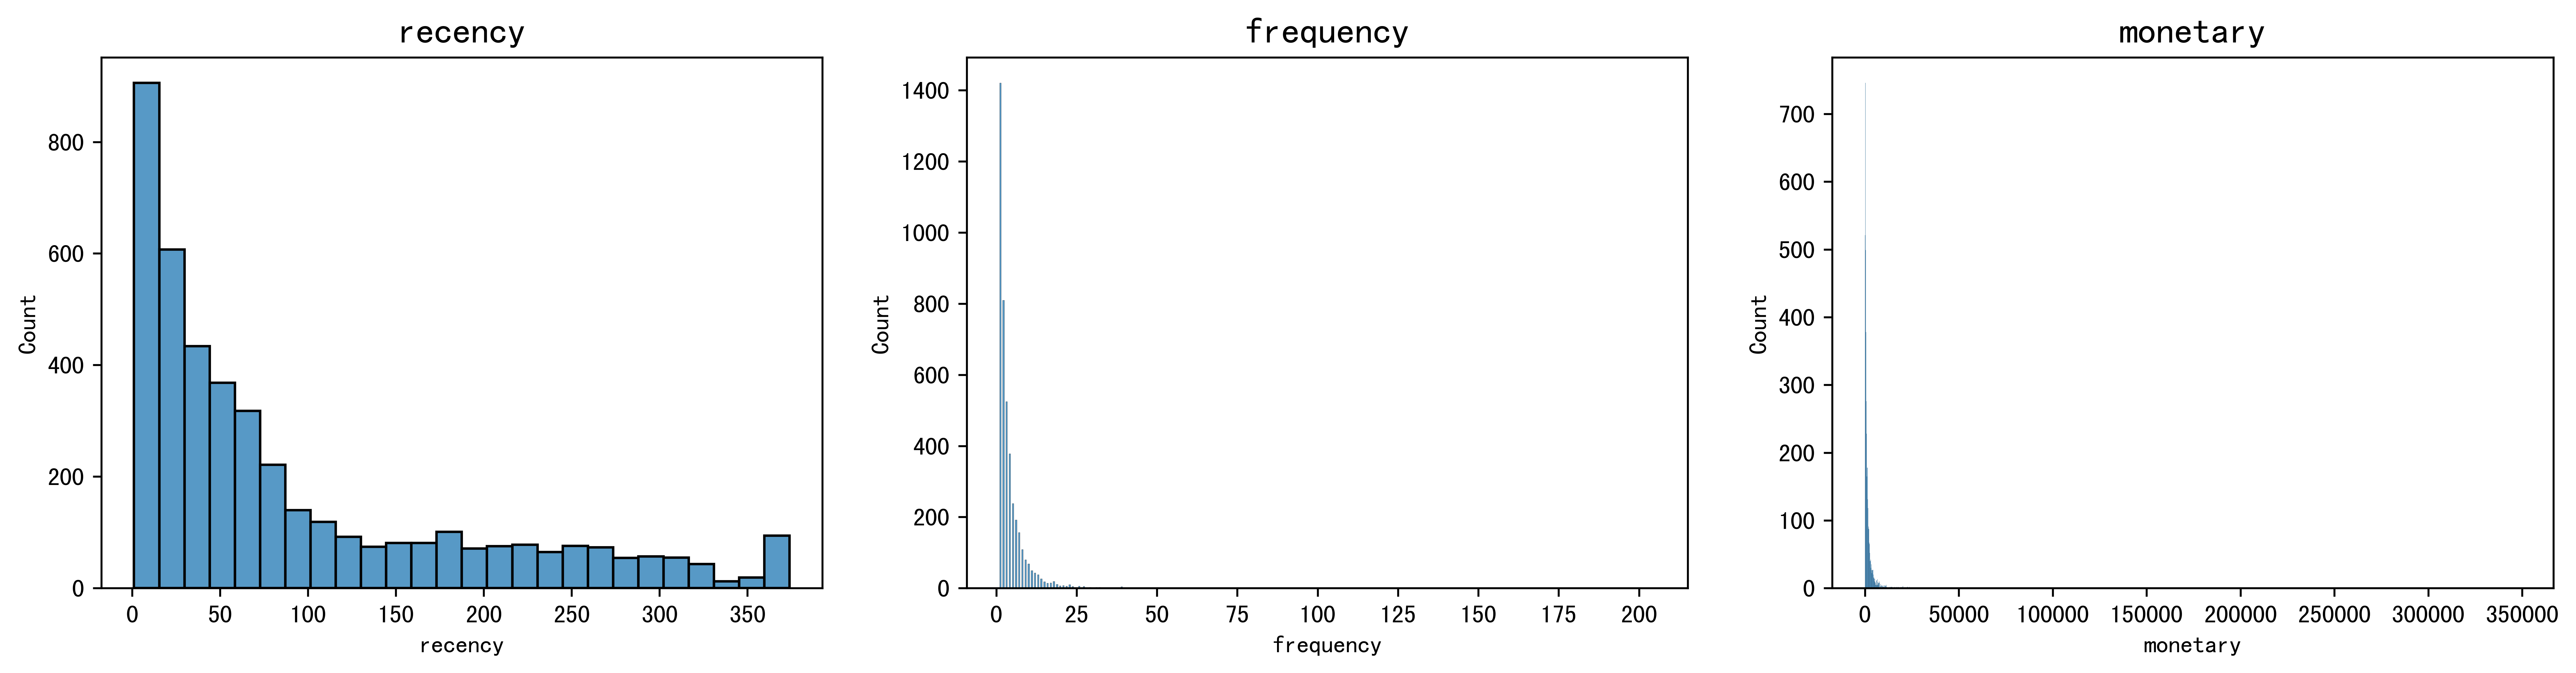

In [19]:
def data_distribution(keyvalue,data):
    plt.figure(figsize=(18,4),dpi=600)
    j = 1
    for i in keyvalue:
        plt.subplot(1,3,j)
        sns.histplot(data[i])
        plt.title(i,fontsize=15)
        j+=1
        
keyvalue = ['recency','frequency','monetary']
data_distribution(keyvalue,rfm)

### 数据分箱，计算RFM分数实现用户分群

In [20]:
rfm['recency_score'] = pd.qcut(rfm['recency'],5,labels = [5,4,3,2,1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'),5,labels = [1,2,3,4,5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'],5,labels = [1,2,3,4,5])

In [21]:
rfm['RFM_score'] = (rfm['recency_score'].astype(str)+rfm['frequency_score'].astype(str))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
Customer ID,,,,,,,
12346.00000,165,11,372.86000,2,5,2,25
12347.00000,3,2,1323.32000,5,2,4,52
12348.00000,74,1,222.16000,2,1,1,21
12349.00000,43,3,2671.14000,3,3,5,33
12351.00000,11,1,300.93000,5,1,2,51


In [22]:
rfm[rfm['RFM_score']=='55'].head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score
Customer ID,,,,,,,
12415.00000,11,7,19543.84000,5,5,5,55
12431.00000,9,13,4370.52000,5,5,5,55
12471.00000,10,49,20139.74000,5,5,5,55
12472.00000,5,13,11308.48000,5,5,5,55
12474.00000,14,13,5048.66000,5,5,5,55


### 根据RF分数进行客户分群

In [23]:
#正则表达式
seg_map = {
    r'[1-2][1-2]':'沉睡用户',
    r'[1-2][3-4]':'流失风险用户',
    r'[1-2]5':'不能失去用户',
    r'3[1-2]':'即将沉睡用户',
    r'33':'需要关注用户',
    r'[3-4][4-5]':'忠实用户',
    r'41':'潜在用户',
    r'51':'新用户',
    r'[4-5][2-3]':'潜在忠诚用户',
    r'5[4-5]':'冠军用户',
}
rfm['segment']= rfm['RFM_score'].replace(seg_map,regex=True)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,segment
Customer ID,,,,,,,,
12346.00000,165,11,372.86000,2,5,2,25,不能失去用户
12347.00000,3,2,1323.32000,5,2,4,52,潜在忠诚用户
12348.00000,74,1,222.16000,2,1,1,21,沉睡用户
12349.00000,43,3,2671.14000,3,3,5,33,需要关注用户
12351.00000,11,1,300.93000,5,1,2,51,新用户


In [24]:
rfm[rfm['segment']=='忠实用户'].index

Float64Index([12359.0, 12402.0, 12409.0, 12417.0, 12422.0, 12435.0, 12437.0,
              12454.0, 12476.0, 12500.0,
              ...
              18220.0, 18223.0, 18231.0, 18236.0, 18241.0, 18247.0, 18276.0,
              18277.0, 18283.0, 18287.0],
             dtype='float64', name='Customer ID', length=742)

In [25]:
rfm.groupby('segment')[['recency','frequency','monetary']].agg(['mean','count','max'])

recency            frequency              monetary        \
             mean count  max      mean count  max       mean count   
segment                                                              
不能失去用户  124.11688    77  298   9.11688    77   46 4099.45000    77   
冠军用户      7.11916   663   15  12.55354   663  205 6852.26417   663   
即将沉睡用户   53.81924   343   71   1.20117   343    2  441.32000   343   
忠实用户     36.28706   742   71   6.83019   742   42 2746.06735   742   
新用户       8.58000    50   15   1.00000    50    1  386.19920    50   
沉睡用户    214.05703  1017  374   1.12586  1017    2  403.18339  1017   
流失风险用户  152.15876   611  372   3.07365   611    6 1188.87832   611   
潜在忠诚用户   18.79304   517   36   2.01741   517    3  729.51099   517   
潜在用户     25.74713    87   36   1.00000    87    1  367.08678    87   
需要关注用户   53.26570   207   71   2.44928   207    3 1060.35700   207   

                      
                 max  
segment               
不能失去用户   26286.75000  
冠军用户    349164.35000  
即将沉睡用户    3502.48000  
忠实用户     50291.38000  
新用户       2945.38000  
沉睡用户     11880.84000  
流失风险用户   34095.26000  
潜在忠诚用户   12079.99000  
潜在用户      2389.62000  
需要关注用户   13544.99000

### 根据RFM分数加权再分箱对客户进行分群

In [26]:
#计算加权分数
rfm['RFM_wscore'] = rfm[['recency_score','frequency_score','monetary_score']].sum(axis=1)
#按照分数打标签
labels = ['general','sliver','gold','diamond']
rfm['Category'] = pd.qcut(rfm['RFM_wscore'],4,labels = labels)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_score,segment,RFM_wscore,Category
Customer ID,,,,,,,,,,
12346.00000,165,11,372.86000,2,5,2,25,不能失去用户,9,sliver
12347.00000,3,2,1323.32000,5,2,4,52,潜在忠诚用户,11,gold
12348.00000,74,1,222.16000,2,1,1,21,沉睡用户,4,general
12349.00000,43,3,2671.14000,3,3,5,33,需要关注用户,11,gold
12351.00000,11,1,300.93000,5,1,2,51,新用户,8,sliver


In [27]:
rfm['Category'].value_counts().sort_index(ascending=True)

general    1243
sliver     1125
gold       1025
diamond     921
Name: Category, dtype: int64